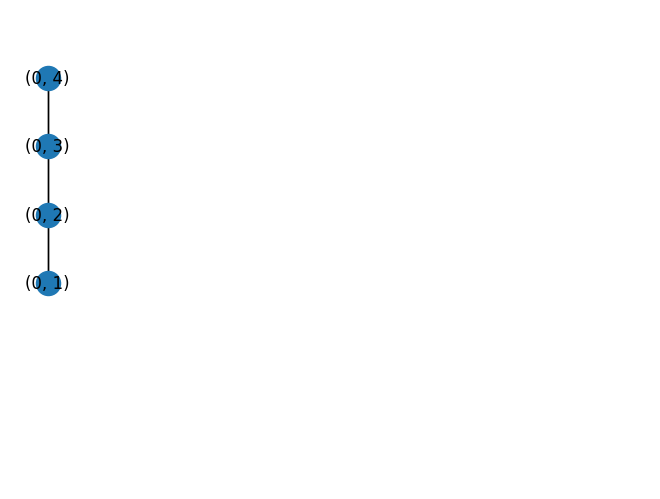

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math
import csv
G = nx.Graph()



points1 = [] #placement of lidars for one side
points2 = [] #placement of lidars for other side
points3 = [] #vertices to cover


# for i in range(1, 6, 2):
#     point = (i, 1)
#     points1.append(point)

# for i in range(1, 6, 2):
#     point = (i, 4)
#     points2.append(point)

# for i in range(0, 7):
#     for j in range(2, 4):
#         point = (i, j)
#         points3.append(point)

# G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
# for node1 in points1:
#   for j in range (node1[1]+1, node1[1]+3):
#     if(j==node1[1]+1):
#       for i in range(node1[0]-2, node1[0]+3):
#         if (i,j) in points3:
#           G.add_edge(tuple(node1), (i,j))
#     if(j== node1[1]+2):
#       for i in range(node1[0]-1, node1[0]+2):
#         if (i,j) in points3:
#           G.add_edge(tuple(node1), (i,j))
# for node2 in points2:
#   for j in range (node2[1]-2,node2[1]):
#     if(j== node2[1]-2):
#       for i in range(node2[0]-1, node2[0]+2):
#         if (i,j) in points3:
#           G.add_edge(tuple(node2), (i,j))
#     if(j==node2[1]-1):
#       for i in range(node2[0]-2, node2[0]+3):
#         if (i,j) in points3:
#           G.add_edge(tuple(node2), (i,j))
    
for i in range(0, 1, 1):
    point = (i, 1)
    points1.append(point)

for i in range(0, 1, 1):
    point = (i, 4)
    points2.append(point)

for i in range(0, 1):
    for j in range(2, 4):
        point = (i, j)
        points3.append(point)
G.add_nodes_from(points1 + points2 + points3)


#edge that represents scope between lidar placement and vertices to cover
for node1 in points1:
  for j in range (node1[1]+1, node1[1]+3):
    if(j==node1[1]+1):
      for i in range(node1[0]-2, node1[0]+3):
        if (i,j) in points3:
          G.add_edge(tuple(node1), (i,j))
    if(j== node1[1]+2):
      for i in range(node1[0]-1, node1[0]+2):
        if (i,j) in points3:
          G.add_edge(tuple(node1), (i,j))
for node2 in points2:
  for j in range (node2[1]-2,node2[1]):
    if(j== node2[1]-2):
      for i in range(node2[0]-1, node2[0]+2):
        if (i,j) in points3:
          G.add_edge(tuple(node2), (i,j))
    if(j==node2[1]-1):
      for i in range(node2[0]-2, node2[0]+3):
        if (i,j) in points3:
          G.add_edge(tuple(node2), (i,j))
#Draw the graph

pos = {node: node for node in G.nodes()} 
nx.draw(G, pos,with_labels=True)

plt.xlim(-1, 16)
plt.ylim(-2, 5)

plt.xticks(range(0, 16))
plt.yticks(range(1, 5))

plt.show()
pointsL = points1 + points2


In [196]:
from typing import List, Union

import numpy as np
import random
from time import time
import math
from dotmap import DotMap

def random_start(n_blades: int) -> (np.ndarray, np.ndarray):
    """
    Initialize random blade configuration for start

    :param n_blades: number of blades
    :return: random solution vector in one hot, random solution vector in dec
    """
    slots = np.zeros((n_blades, n_blades), dtype=int)
    range_blade = np.arange(0, n_blades)
    np.random.shuffle(range_blade)

    for i, slot in enumerate(slots):
        slot[range_blade[i]] = 1

    slots = slots.flatten()
    return slots, range_blade
random_start(8)
def one_hot_to_dec(warm_start: List, n_blades: int) -> List:
    """
    Transform one hot encoded vector into decimal vector

    :param warm_start: one hot vector
    :param n_blades: number of blades
    :return: decimal vector
    """
    warm_start_dec = []
    for i in range(n_blades):
        slot = warm_start[i * n_blades : (i + 1) * n_blades]
        warm_start_dec.append(slot.index(1))
    return warm_start_dec


def unbalance_sa_solve(
    qubo: np.ndarray,
    n_iter: int = 1000,
    n_temp_iter: int = 10,
    temp: float = 5000000,
    warm_start: Union[List, np.ndarray] = None,
) -> DotMap:
    """
    Custom simulated annealing solver for the unbalance problem
    Mutation only in valid solution space

    :param qubo: qubo to solve
    :param n_iter: number of runs
    :param n_temp_iter: number of mutations
    :param temp: starting temperature
    :param warm_start: warm start solution vector
    :return: solution with samples, energies and times
    """
    samples = []
    energies = []
    n_blades = int(math.sqrt(len(qubo)))
    indices = list(range(0, n_blades))

    # evaluate energy of vector based on qubo
    #f = lambda x: (x.T @ qubo @ x)
    def f(x):
        #print(x.shape,qubo.shape)
        return x.T @ qubo @ x
    start_time = time()

    for _ in range(n_iter):
        # define start vector
        if warm_start is None:
            x, curr_dec = random_start(n_blades)
            #x, curr_dec = 
        else:
            x = np.array(warm_start)
            curr_dec = one_hot_to_dec(warm_start, n_blades)

        # evaluate start vector
        curr, curr_eval = x, f(x)
        best, best_eval = curr, curr_eval

        for i in range(n_temp_iter):

            # randomly switch two blades
            candidate = np.copy(curr)
            candidate_dec = curr_dec.copy()
            swap_pos = random.sample(indices, 2)

            candidate[swap_pos[0] * n_blades + candidate_dec[swap_pos[0]]] = 0
            candidate[swap_pos[0] * n_blades + candidate_dec[swap_pos[1]]] = 1

            candidate[swap_pos[1] * n_blades + candidate_dec[swap_pos[1]]] = 0
            candidate[swap_pos[1] * n_blades + candidate_dec[swap_pos[0]]] = 1

            candidate_dec[swap_pos[0]], candidate_dec[swap_pos[1]] = (
                candidate_dec[swap_pos[1]],
                candidate_dec[swap_pos[0]],
            )

            # evaluate new vector
            candidate_eval = f(candidate)

            # keep best vector
            if candidate_eval <= best_eval:
                best, best_eval = candidate, candidate_eval

            # update temperature according to Metropolis–Hastings algorithm
            diff = candidate_eval - curr_eval
            t = temp / float(i + 1)
            if diff <= 0:
                curr, curr_eval, curr_dec = candidate, candidate_eval, candidate_dec
            else:
                metropolis_eval = math.exp(-diff / t)
                if random.random() < metropolis_eval:
                

            # base new mutations on new vector
            
                    curr, curr_eval, curr_dec = candidate, candidate_eval, candidate_dec

        samples.append(best.tolist())
        energies.append(best_eval)

    runtime_sa = time() - start_time
    solution = DotMap(
        solver="unbalance_sa",
        samples=samples,
        energies=energies,
        runtime=DotMap(total=runtime_sa, qpu=None),
    )
    return solution


16
[[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

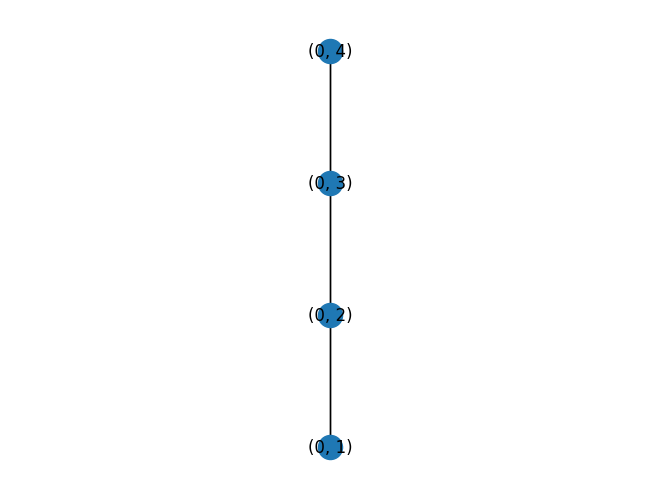

In [197]:
# print(pointsL)

QUBO : np.array
with open("matrice_QUBO_JS.npy", 'rb') as file:
    QUBO = np.load(file)
    
sizeQUBO = len(QUBO)
print(sizeQUBO)
solution = unbalance_sa_solve(QUBO)
sample =solution["samples"]
energy = solution["energies"]
print(sample)
print(energy)
S = []
for i in range(len(pointsL)):
        if sample[0][i]:
            S.append(pointsL[i])
print(sample[0])

pos = {node: node for node in G.nodes()}
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_nodes(G, pos, S, node_color='red')